 primary author: elaine

In [1]:
# this code is for an elaine problem:
import sys
sys.path.append('/Users/elainecunha/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages')

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

from config import *

### Generate Data

In [3]:
# training data
x_train, y_train, x_test = utils.generate_data(training_seed)

# for model evaluation: computing log likelihood
x_valid, y_valid, x_test_not_used = utils.generate_data(valid_seed)

### Train NLM

In [18]:
opt_params["max_iteration"] = real_max_iteration
# train NLMs
reg_params = [0.0, 1.0]
nlms = []
log_ls = []

for i,r in enumerate(reg_params):

    # append model to list of NLMs
    nlms.append(NLM(prior_variance,y_noise_variance, r, nlm_architecture, random_seed))
    
    # train model
    t0 = time.time()
    nlms[i].train(x_train, y_train, opt_params)
    nlm_time = np.round(time.time() - t0, 3)
    log_ls.append(nlms[i].get_log_l(x_train,y_train,x_valid,y_valid))
    
    print('Model {}: {} seconds'.format(i, nlm_time))

 Iteration 9900 lower bound 7.333249296412261; gradient mag: 4.65454810283834155
Done Training
Model 0: 777.45 seconds
 Iteration 9900 lower bound 18.782803863651225; gradient mag: 2.3778572144772616
Done Training
Model 1: 767.435 seconds


### Calculate Posterior and Prior Predictives

In [19]:
# calculate posterior and prior predictives
post_pred_mean = []
post_pred_upper = []
post_pred_lower = []
prior_predictive_samples = []

for model in nlms:
    
    # get posterior and prior samples
    post_pred, post_pred_samples = model.predict(x_test, prior=False)
    prior_pred, prior_pred_samples = model.predict(x_test, prior=True)

    # calculate posterior predictive mean
    pp_mean = np.mean(post_pred_samples, axis=0)
    pp_upper = np.percentile(post_pred_samples, 97.5, axis=0)
    pp_lower = np.percentile(post_pred_samples, 2.5, axis=0)

    # store results
    post_pred_mean.append(pp_mean)
    post_pred_upper.append(pp_upper)
    post_pred_lower.append(pp_lower)
    prior_predictive_samples.append(prior_pred_samples)

### Plot Results

In [20]:
# calculate ground truth line
f = lambda x: (x**3)
x_true = np.linspace(-10, 10, 100)
y_true = f(x_true)

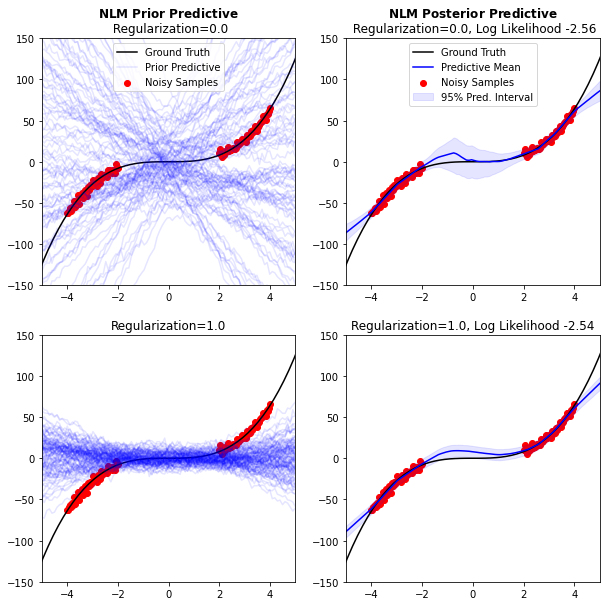

In [28]:
# plot

num_figures = len(nlms)

fig,ax = plt.subplots(num_figures, 2, figsize=(10,10))

for i,model in enumerate(nlms):
    ax[i][0].scatter(x_train, y_train, color='red', label='Noisy Samples')
    ax[i][1].scatter(x_train, y_train, color='red', label='Noisy Samples')
    ax[i][0].plot(x_true, y_true, color='black', label='Ground Truth')
    ax[i][1].plot(x_true, y_true, color='black', label='Ground Truth')
    ax[i][1].plot(x_test.flatten(), post_pred_mean[i], color='blue', label='Predictive Mean')
    ax[i][1].fill_between(x_test.flatten(), post_pred_upper[i], post_pred_lower[i], color='blue', alpha=0.1, label='95% Pred. Interval') 
    ax[i][0].plot(x_test.flatten(), prior_predictive_samples[i][j,:], alpha = 0.1, color='blue', label='Prior Predictive')
    
    for j in range(1, prior_predictive_samples[i].shape[1]+1):
        
        ax[i][0].plot(x_test.flatten(), prior_predictive_samples[i][j,:], alpha = 0.1, color='blue')

    ax[i][0].axis([-5, 5, -150, 150])
    ax[i][1].axis([-5, 5, -150, 150])
    if i == 0:
        ax[i][0].set_title(r'$\bf{NLM\ Prior\ Predictive}$' + f'\n Regularization={reg_params[i]}')
        ax[i][1].set_title(r'$\bf{NLM\ Posterior\ Predictive}$' + f'\n Regularization={reg_params[i]}, Log Likelihood {round(log_ls[i],2)}')
    else:
        ax[i][0].set_title(f'Regularization={reg_params[i]}')
        ax[i][1].set_title(f'Regularization={reg_params[i]}, Log Likelihood {round(log_ls[i],2)}')
        
ax[0][0].legend(loc='upper center')
ax[0][1].legend(loc='upper center')

plt.show()
fig.savefig("fig_final/NLM_Predictives.png")